In [94]:
import numpy as np
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
from scipy.constants import mu_0
from scipy.constants import elementary_charge as q_e
from astropy.convolution import convolve, convolve_fft
import scipy
import visit_writer

import structured_3d_vtk as struc_3d
reload(struc_3d)

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

# Define functions

In [3]:
def prepare_idl_quantity(name, planes, bounds=None):
    r"""
    """
    measurements = struc_3d.read_idl(name)
    if bounds:
        measurements = struc_3d.remove_points_out_of_bounds(measurements, 
                                                            bounds[0], bounds[1], planes)
    for plane in planes:
        measurements[plane] = struc_3d.average_duplicate_points(measurements[plane])
    return measurements

In [4]:
def combine_all_planes(measurements, planes):
    r"""
    """
    all_planes = dict(measurements[planes[0]])
    all_planes['z_out'] = planes[0]*np.ones(all_planes['x_out'].size) 
    for plane in planes[1:]:
        for key in ['x_out', 'y_out']:
            all_planes[key] = np.concatenate((all_planes[key], 
                                              measurements[plane][key]))
        all_planes['z_out'] = np.concatenate((all_planes['z_out'],
                                              plane*np.ones(measurements[plane]['x_out'].size)))
        for key in ['std', 'a_out']:
            for time_point in xrange(measurements[plane]['delays'].size):
                all_planes[key][time_point] = np.concatenate((all_planes[key][time_point], 
                                                              measurements[plane][key][time_point]))
    return all_planes

In [5]:
def remove_points_outside_convex(measurements,
                                 x_min= -0.025, x_max=0.025,
                                 y_min=-0.016, y_max=0.017,
                                 z_min=0.249, z_max=0.416):
    r"""
    """
    points = np.dstack((measurements['x_out'], 
                        measurements['y_out'], 
                        measurements['z_out']))[0]
    outside_convex_volume = np.where(np.logical_or.reduce((points[:, 0] < x_min, 
                                                           points[:, 0] > x_max, 
                                                           points[:, 1] < y_min,
                                                           points[:, 1] > y_max,
                                                           points[:, 2] < z_min,
                                                           points[:, 2] > z_max)))[0]
    for key in ['x_out', 'y_out', 'z_out']:
        measurements[key] = np.delete(measurements[key], 
                                      outside_convex_volume)
    for key in ['std', 'a_out']:
        for time_point in xrange(measurements['delays'].size):
            measurements[key][time_point] = np.delete(measurements[key][time_point], 
                                                      outside_convex_volume)
    return measurements

In [6]:
def prepare_for_unstructured_vtk(measurements, quantity_name):
    r"""
    """
    points = np.dstack((measurements['x_out'], 
                        measurements['y_out'], 
                        measurements['z_out']))[0]
    triangulation = Delaunay(points)
    points = tuple(points.ravel())
    connectivity = tuple([(visit_writer.tetrahedron, int(simplex[0]), 
                           int(simplex[1]), int(simplex[2]), int(simplex[3])) 
                           for simplex in triangulation.simplices])
    variables_all_time = []
    for time_point in xrange(measurements['delays'].size):
        variables = ((quantity_name, 1, 1, tuple(measurements['a_out'][time_point])),)
        variables_all_time.append(variables)
    return points, connectivity, variables_all_time

In [7]:
def give_delaunay_and_interpolator(measurements):
    r"""
    """
    points = np.dstack((measurements['x_out'], 
                        measurements['y_out'], 
                        measurements['z_out']))[0]
    triangulation = Delaunay(points)
    interpolators = []
    for time_point in xrange(measurements['delays'].size):
        interpolators.append(LinearNDInterpolator(points, measurements['a_out'][time_point]))
    return triangulation, interpolators

In [8]:
def write_all_time_unstructured(file_prefix, points, connectivity, variables_all_time):
    r"""
    """
    for time_point in xrange(len(variables_all_time)):
        path = file_prefix + str(time_point).zfill(4)
        visit_writer.WriteUnstructuredMesh(path, 1, points,
                                           connectivity, 
                                           variables_all_time[time_point])

In [9]:
def save_idl_quantity_to_unstructured_grids(idl_quantity_name,
                                            visit_quantity_name,
                                            date, 
                                            planes=[0.249, 0.302, 0.357, 0.416],
                                            file_name_descriptor='_all_planes_convex_unstructured_grid_',
                                            x_min= -0.021, x_max=0.014,
                                            y_min=-0.016, y_max=0.017,
                                            z_min=0.249, z_max=0.416,
                                            bounds=None):
    r"""
    """
    file_prefix = '../output/' + date + '/' + visit_quantity_name + file_name_descriptor
    measurements = prepare_idl_quantity(idl_quantity_name, planes, bounds=bounds)
    all_planes = combine_all_planes(measurements, planes) 
    all_planes = remove_points_outside_convex(all_planes, 
                                              x_min=x_min, x_max=x_max,
                                              y_min=y_min, y_max=y_max,
                                              z_min=z_min, z_max=z_max)
    assert len(all_planes['x_out']) == len(all_planes['y_out']) == len(all_planes['z_out'])
    (points, 
     connectivity, 
     variables_all_time) = prepare_for_unstructured_vtk(all_planes, visit_quantity_name)
    assert len(points) == len(all_planes['x_out'])*3
    assert len(variables_all_time[0][0][3]) == len(all_planes['x_out'])
    write_all_time_unstructured(file_prefix, points, 
                                connectivity, variables_all_time)
    return all_planes 

In [10]:
def triangulate_derivatives(mesh, triangulation, interpolators, increment=0.00001):
    r"""
    """
    derivative_meshes = []
    for time_point in xrange(len(interpolators)):
        print time_point
        interpolator = interpolators[time_point]
        d_dx_mesh = np.zeros(mesh[0].shape)
        d_dy_mesh = np.zeros(mesh[0].shape)
        d_dz_mesh = np.zeros(mesh[0].shape)
        points = np.dstack((mesh[0].ravel(),
                            mesh[1].ravel(),
                            mesh[2].ravel()))
        values = interpolator(points)
        d_dx = (interpolator(points + np.asarray([increment, 0, 0])) - values) / increment
        d_dy = (interpolator(points + np.asarray([0, increment, 0])) - values) / increment
        d_dz = (interpolator(points + np.asarray([0, 0, increment])) - values) / increment
        d_dx_mesh = d_dx.reshape(mesh[0].shape)
        d_dy_mesh = d_dy.reshape(mesh[0].shape)
        d_dz_mesh = d_dz.reshape(mesh[0].shape)
        derivative_meshes.append([d_dx_mesh, d_dy_mesh, d_dz_mesh])
    return derivative_meshes

In [11]:
def remove_edges_derivative_meshes(derivative_meshes,
                                   x_start=2, x_end=None, 
                                   y_start=0, y_end=-2, 
                                   z_start=0, z_end=-1):
    r"""
    """
    for time_point in xrange(len(derivative_meshes)):
        for index in xrange(len(derivative_meshes[time_point])):
            derivative_meshes[time_point][index] = derivative_meshes[time_point][index][y_start:y_end, x_start:x_end, z_start:z_end]
    return derivative_meshes

In [12]:
def remove_edges_vector_quantity_meshes(quantity_meshes,
                                        x_start=2, x_end=None, 
                                        y_start=0, y_end=-2, 
                                        z_start=0, z_end=-1):
    r"""
    """
    for index in xrange(len(quantity_meshes)):
        for time_point in xrange(len(quantity_meshes[index])):
            quantity_meshes[index][time_point] = quantity_meshes[index][time_point][y_start:y_end, x_start:x_end, z_start:z_end]
    return quantity_meshes

In [13]:
def remove_edges_scalar_quantity_meshes(quantity_meshes,
                                        x_start=2, x_end=None, 
                                        y_start=0, y_end=-2, 
                                        z_start=0, z_end=-1):
    r"""
    """
    for time_point in xrange(len(quantity_meshes)):
        quantity_meshes[time_point] = quantity_meshes[time_point][y_start:y_end, x_start:x_end, z_start:z_end]
    return quantity_meshes

In [14]:
def remove_edges_mesh(mesh,
                      x_start=2, x_end=None, 
                      y_start=0, y_end=-2, 
                      z_start=0, z_end=-1):
    r"""
    """
    for index in xrange(len(mesh)):
        mesh[index] = mesh[index][y_start:y_end, x_start:x_end, z_start:z_end]
    return mesh

In [15]:
def prepare_for_rectilinear_grid(mesh, quantities, quantity_names):
    r"""
    """
    x = tuple(np.unique(mesh[0]))
    y = tuple(np.unique(mesh[1]))
    z = tuple(np.unique(mesh[2]))
    variables_all_time = []
    for time_point in xrange(len(quantities[0])):
        variables = [(quantity_names[index], 1, 1, 
                      tuple(np.swapaxes(np.swapaxes(quantities[index][time_point], 1, 2), 0, 1).ravel()))
                     for index in xrange(len(quantities))]
        variables_all_time.append(variables)
    return x, y, z, variables_all_time

In [16]:
def current_on_mesh(derivative_meshes_all_directions, mu_0=1.2566e-6):
    r"""
    """
    j_field_x = [] 
    j_field_y = []
    j_field_z = []
    for time_point in xrange(len(derivative_meshes_all_directions[0])):
        dBx_dy = derivative_meshes_all_directions[0][time_point][1]
        dBx_dz = derivative_meshes_all_directions[0][time_point][2]
        dBy_dx = derivative_meshes_all_directions[1][time_point][0]
        dBy_dz = derivative_meshes_all_directions[1][time_point][2]
        dBz_dx = derivative_meshes_all_directions[2][time_point][0]
        dBz_dy = derivative_meshes_all_directions[2][time_point][1]
        j_x = 1./(mu_0) * (dBz_dy - dBy_dz)
        j_y = 1./(mu_0) * (dBx_dz - dBz_dx)
        j_z = 1./(mu_0) * (dBy_dx - dBx_dy)
        j_field_x.append(j_x)
        j_field_y.append(j_y)
        j_field_z.append(j_z)
    current = [j_field_x, j_field_y, j_field_z]    
    return current

In [17]:
def b_field_on_mesh(interpolators_all_directions, mesh, bias=2e-2):
    r"""
    """
    shape = mesh[0].shape
    points = np.swapaxes(np.asarray([mesh[0].ravel(), mesh[1].ravel(), mesh[2].ravel()]), 0, 1)
    b_field_x = []
    b_field_y = []
    b_field_z = []
    b_field_norm_x = []
    b_field_norm_y = []
    b_field_norm_z = []
    for time_point in xrange(len(interpolators_all_directions[0])):        
        b_x = interpolators_all_directions[0][time_point](points)  
        b_y = interpolators_all_directions[1][time_point](points)
        b_z = interpolators_all_directions[2][time_point](points)
        b_x.resize(shape)
        b_y.resize(shape)
        b_z.resize(shape)
        b_z += bias 
        b_x_norm = b_x / np.sqrt(b_x**2. + b_y**2. + b_z**2.)
        b_y_norm = b_y / np.sqrt(b_x**2. + b_y**2. + b_z**2.)
        b_z_norm = b_z / np.sqrt(b_x**2. + b_y**2. + b_z**2.)    
        b_field_x.append(b_x)
        b_field_y.append(b_y)
        b_field_z.append(b_z)
        b_field_norm_x.append(b_x_norm)
        b_field_norm_y.append(b_y_norm)
        b_field_norm_z.append(b_z_norm)
    b_field = [b_field_x, b_field_y, b_field_z]
    b_field_norm = [b_field_norm_x, b_field_norm_y, b_field_norm_z]
    return b_field, b_field_norm

In [18]:
def scalar_on_mesh(interpolators, mesh):
    r"""
    """
    shape = mesh[0].shape
    points = np.swapaxes(np.asarray([mesh[0].ravel(), mesh[1].ravel(), mesh[2].ravel()]), 0, 1)
    scalar_all_times = []
    for time_point in xrange(len(interpolators)):
        scalar = interpolators[time_point](points)
        scalar.resize(shape)
        scalar_all_times.append(scalar)
    return scalar_all_times

In [19]:
def write_fields_and_currents_to_structured_mesh(date, visit_file_name, 
                                                 x, y, z, data):
    r"""
    """
    file_prefix = '../output/' + date + '/' + visit_file_name
    for time_point in xrange(len(data)):
        print time_point
        path = file_prefix + str(time_point).zfill(4)  
        visit_writer.WriteRectilinearMesh(path, 1, x, y, z, 
                                          data[time_point])

In [20]:
def bdot_probe_extent():
    r"""
    """
    x_min = -0.026
    x_max = 0.024
    y_min = -0.02 
    y_max = 0.028
    z_min = 0.249 
    z_max = 0.416
    return x_min, x_max, y_min, y_max, z_min, z_max

def joint_extent():
    r"""
    """
    x_min = -0.022
    x_max = 0.024
    y_min = -0.02 
    y_max = 0.024
    z_min = 0.249 
    z_max = 0.416
    return x_min, x_max, y_min, y_max, z_min, z_max

In [21]:
def calc_ion_velocity_term_1(current, density, charge):
    r"""
    """
    denominator = density*charge
    term = [current[0]/denominator,
            current[1]/denominator,
            current[2]/denominator]
    return term

In [22]:
def calc_ion_velocity_term_2(b_field_norm, alpha):
    r"""
    """
    return alpha*b_field_norm

In [23]:
def curl_on_mesh(quantity, mesh):
    r"""
    """
    dx = mesh[0][0, 1, 0] - mesh[0][0, 0, 0]
    dy = mesh[1][1, 0, 0] - mesh[1][0, 0, 0]
    dz = mesh[2][0, 0, 1] - mesh[2][0, 0, 0]
    dx_dy = np.gradient(quantity[0], axis=2)/dy
    dx_dz = np.gradient(quantity[0], axis=3)/dz
    dy_dx = np.gradient(quantity[1], axis=1)/dx
    dy_dz = np.gradient(quantity[1], axis=3)/dz
    dz_dx = np.gradient(quantity[2], axis=1)/dx
    dz_dy = np.gradient(quantity[2], axis=2)/dy
    curl_x = dz_dy - dy_dz
    curl_y = dx_dz - dz_dx
    curl_z = dy_dx - dx_dy
    return curl_x, curl_y, curl_z

In [24]:
def calc_ion_vorticity_term_1(current, density, charge, mesh, filt=None):
    r"""
    """
    return curl_on_mesh(calc_ion_velocity_term_1(current, density, charge), mesh)

In [25]:
def calc_ion_vorticity_term_2(b_field_norm, alpha):
    r"""
    """
    return curl_on_mesh(calc_ion_velocity_term_2(b_field_norm, alpha), mesh)

In [97]:
def boxcar_filter_quantity_mesh(quantity, width):
    r"""
    """
    boxcar = np.ones((width, width, width))
    boxcar /= boxcar.sum()
    return convolve(quantity, boxcar)

# Write all idl quantities to files

In [27]:
bx_all_planes = save_idl_quantity_to_unstructured_grids('bx', 'B_x', '2016-07-26',
                                                        x_min=-0.032, x_max=0.028,
                                                        y_min=-0.022, y_max=0.032, 
                                                        z_min=0.249, z_max=0.416)



In [28]:
by_all_planes = save_idl_quantity_to_unstructured_grids('by', 'B_y', '2016-07-26',
                                                        x_min=-0.032, x_max=0.028,
                                                        y_min=-0.022, y_max=0.032, 
                                                        z_min=0.249, z_max=0.416)


In [29]:
bz_all_planes = save_idl_quantity_to_unstructured_grids('bz', 'B_z', '2016-07-26',
                                                        x_min=-0.032, x_max=0.028,
                                                        y_min=-0.022, y_max=0.032, 
                                                        z_min=0.249, z_max=0.416)


In [30]:
te_all_planes = save_idl_quantity_to_unstructured_grids('te', 'T_e', '2016-07-26', 
                                                        x_min=-0.026, x_max=0.028,
                                                        y_min=-0.03, y_max=0.028, 
                                                        z_min=0.249, z_max=0.416,
                                                        bounds=(1e-3, 1e3))


In [31]:
n_all_planes = save_idl_quantity_to_unstructured_grids('n', 'n', '2016-07-26',
                                                       x_min=-0.026, x_max=0.028,
                                                       y_min=-0.03, y_max=0.028, 
                                                       z_min=0.249, z_max=0.416,
                                                       bounds=(1e3, 1e22))


# Determine derivatives and write to files

In [32]:
bx_triangulation, bx_interpolators = give_delaunay_and_interpolator(bx_all_planes)
by_triangulation, by_interpolators = give_delaunay_and_interpolator(by_all_planes)
bz_triangulation, bz_interpolators = give_delaunay_and_interpolator(bz_all_planes)
te_triangulation, te_interpolators = give_delaunay_and_interpolator(te_all_planes)
n_triangulation, n_interpolators = give_delaunay_and_interpolator(n_all_planes)

# Bdot quantities interpolation

In [82]:
date = '2016-07-30'

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = bdot_probe_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

bx_derivative_meshes = triangulate_derivatives(mesh, bx_triangulation, bx_interpolators, 
                                               increment=0.0000001)
bx_derivative_meshes = remove_edges_derivative_meshes(bx_derivative_meshes)
by_derivative_meshes = triangulate_derivatives(mesh, by_triangulation, by_interpolators, 
                                               increment=0.0000001)
by_derivative_meshes = remove_edges_derivative_meshes(by_derivative_meshes)
bz_derivative_meshes = triangulate_derivatives(mesh, bz_triangulation, bz_interpolators, 
                                               increment=0.0000001)
bz_derivative_meshes = remove_edges_derivative_meshes(bz_derivative_meshes)
mesh = remove_edges_mesh(mesh)

current = current_on_mesh([bx_derivative_meshes, 
                           by_derivative_meshes, 
                           bz_derivative_meshes])
b_field, b_field_norm = b_field_on_mesh([bx_interpolators, 
                                         by_interpolators,
                                         bz_interpolators], mesh)

temperature = scalar_on_mesh(te_interpolators, mesh)
density = scalar_on_mesh(n_interpolators, mesh)
density = 1e18

mesh = remove_edges_mesh(mesh,
                         x_start=1, x_end=None, 
                         y_start=0, y_end=None, 
                         z_start=0, z_end=None)
b_field = remove_edges_vector_quantity_meshes(b_field,
                                              x_start=1, x_end=None, 
                                              y_start=0, y_end=None, 
                                              z_start=0, z_end=None)
b_field_norm = remove_edges_vector_quantity_meshes(b_field_norm,
                                                   x_start=1, x_end=None, 
                                                   y_start=0, y_end=None, 
                                                   z_start=0, z_end=None)

current = remove_edges_vector_quantity_meshes(current,
                                              x_start=1, x_end=None, 
                                              y_start=0, y_end=None, 
                                              z_start=0, z_end=None)

fields = [b_field[0], b_field[1], b_field[2], 
          b_field_norm[0], b_field_norm[1], b_field_norm[2],
          current[0], current[1], current[2]]
x, y, z, variables = prepare_for_rectilinear_grid(mesh, fields,
                                                  ['B_x', 'B_y', 'B_z',
                                                   'B_norm_x', 'B_norm_y', 'B_norm_z',
                                                   'j_x', 'j_y', 'j_z'])

write_fields_and_currents_to_structured_mesh(date, 'b_field_and_derivatives', x, y, z, variables)

0
1
2
3
4
5
6
7
8
9
10
11
12


KeyboardInterrupt: 

# Joint quantities interpolation

In [81]:
filter_width = 15

In [99]:
date = '2016-07-31'
alpha = 1

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = joint_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

print 'calculate B derivative meshes'
bx_derivative_meshes = triangulate_derivatives(mesh, bx_triangulation, bx_interpolators, 
                                               increment=0.0000001)
bx_derivative_meshes = remove_edges_derivative_meshes(bx_derivative_meshes)
by_derivative_meshes = triangulate_derivatives(mesh, by_triangulation, by_interpolators, 
                                               increment=0.0000001)
by_derivative_meshes = remove_edges_derivative_meshes(by_derivative_meshes)
bz_derivative_meshes = triangulate_derivatives(mesh, bz_triangulation, bz_interpolators, 
                                               increment=0.0000001)
bz_derivative_meshes = remove_edges_derivative_meshes(bz_derivative_meshes)
mesh = remove_edges_mesh(mesh)

current = current_on_mesh([bx_derivative_meshes, 
                           by_derivative_meshes, 
                           bz_derivative_meshes])
b_field, b_field_norm = b_field_on_mesh([bx_interpolators, 
                                         by_interpolators,
                                         bz_interpolators], mesh)

temperature = scalar_on_mesh(te_interpolators, mesh)
density = scalar_on_mesh(n_interpolators, mesh)

#mesh = remove_edges_mesh(mesh,
#                         x_start=1, x_end=None, 
#                         y_start=0, y_end=None, 
#                         z_start=0, z_end=None)
#b_field = remove_edges_vector_quantity_meshes(b_field,
#                                              x_start=1, x_end=None, 
#                                              y_start=0, y_end=None, 
#                                              z_start=0, z_end=None)
#b_field_norm = remove_edges_vector_quantity_meshes(b_field_norm,
#                                                   x_start=1, x_end=None, 
#                                                   y_start=0, y_end=None, 
#                                                   z_start=0, z_end=None)
#current = remove_edges_vector_quantity_meshes(current,
#                                              x_start=1, x_end=None, 
#                                              y_start=0, y_end=None, 
#                                              z_start=0, z_end=None)
#
#temperature = remove_edges_scalar_quantity_meshes()

current = np.asarray(current)
density = np.asarray(density)
b_field_norm = np.asarray(b_field_norm)

print 'filter density and current'
for time_point in xrange(len(current[0])):
    print 'density', time_point
    density[time_point] = boxcar_filter_quantity_mesh(density[time_point], filter_width)

for direction in xrange(len(current)):
    for time_point in xrange(len(current[0])):
        print 'current', direction,  time_point
        current[direction][time_point] = boxcar_filter_quantity_mesh(current[direction][time_point], filter_width)

density = 1e18*np.ones(density.shape)
        
ion_velocity_term_1 = calc_ion_velocity_term_1(current, density, q_e)
ion_velocity_term_2 = calc_ion_velocity_term_2(b_field_norm, alpha)

ion_vorticity_term_1 = calc_ion_vorticity_term_1(current, density, q_e, mesh)
ion_vorticity_term_2 = calc_ion_vorticity_term_2(b_field_norm, alpha)

print 'filter vorticity'
for direction in xrange(len(ion_vorticity_term_1)):
    for time_point in xrange(len(ion_vorticity_term_1[0])):
        ion_vorticity_term_1[direction][time_point] = boxcar_filter_quantity_mesh(ion_vorticity_term_1[direction][time_point], filter_width)
        ion_vorticity_term_2[direction][time_point] = boxcar_filter_quantity_mesh(ion_vorticity_term_2[direction][time_point], filter_width)

fields = (list(b_field) + list(b_field_norm) + list(current) + 
          [density] + [temperature] +
          list(ion_velocity_term_1) + list(ion_velocity_term_2) +
          list(ion_vorticity_term_1) + list(ion_vorticity_term_2))

x, y, z, variables = prepare_for_rectilinear_grid(mesh, fields,
                                                  ['B_x', 'B_y', 'B_z',
                                                   'B_norm_x', 'B_norm_y', 'B_norm_z',
                                                   'j_x', 'j_y', 'j_z', 'n', 'Te',
                                                   'u_i_term1_x', 'u_i_term1_y', 'u_i_term1_z',
                                                   'u_e_norm_x', 'u_e_norm_y', 'u_e_norm_z',
                                                   'w_i_term1_x', 'w_i_term1_y', 'w_i_term1_z',
                                                   'w_i_term2_x', 'w_i_term2_y', 'w_i_term2_z'])

write_fields_and_currents_to_structured_mesh(date, 'Bdot_triple_probe_quantities', x, y, z, variables)

calculate B derivative meshes
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
filter density and current
density 0
density 1
density 2
density 3
density 4
density 5
density 6
density 7
density 8
density 9
density 10
density 11
density 12
density 13
density 14
density 15
density 16
density 17
density 18
density 19
density 20
current 0 0
current 0 1
current 0 2
current 0 3
current 0 4
current 0 5
current 0 6
current 0 7
current 0 8
current 0 9
current 0 10
current 0 11
current 0 12
current 0 13
current 0 14
current 0 15
current 0 16
current 0 17
current 0 18
current 0 19
current 0 20
current 1 0
current 1 1
current 1 2
current 1 3
current 1 4
current 1 5
current 1 6
current 1 7
current 1 8
current 1 9
current 1 10
current 1 11
current 1 12
current 1 13
current 1 14
current 1 15
current 1 16
current 1 17
current 1 18
current 1 19
current 1 20
current 2 0
current 2 1
current 2 2
c

In [70]:
curl_on_mesh(alpha*b_field_norm, mesh)

(array([[[[-0.31427103, -0.20663493, -0.08515619, ...,  0.11431057,
            0.11854088,  0.12060739],
          [-0.31376222, -0.31056629, -0.31140749, ..., -0.09685125,
           -0.07741112, -0.06495012],
          [-0.17747021, -0.17144667, -0.19556052, ...,  0.19642876,
            0.19438401,  0.19337223],
          ..., 
          [ 0.02126376,  0.02102088,  0.02078355, ...,  0.66428068,
            0.66674897,  0.66921228],
          [ 0.01801195,  0.0178254 ,  0.01764442, ...,  0.76669052,
            0.77037302,  0.77405038],
          [ 0.01648126,  0.01639361,  0.0163072 , ...,  0.53967163,
            0.54336617,  0.54705532]],
 
         [[-0.39391685, -0.25760807, -0.09951237, ...,  0.26301958,
            0.27546042,  0.28574633],
          [-0.40010099, -0.3983988 , -0.39968228, ..., -0.00828775,
            0.01039238,  0.02247248],
          [-0.42172066, -0.41591468, -0.4099901 , ...,  0.06234788,
            0.06066258,  0.05979722],
          ..., 
          [

In [75]:
np.allclose(ion_velocity_term_2, b_field_norm, equal_nan=True)

True

In [72]:
ion_vorticity_term_1

(array([[[[ -4.91776478e+06,  -5.51526317e+06,  -6.09075154e+06, ...,
            -9.33932308e+06,  -8.43078325e+06,  -7.51873844e+06],
          [ -5.54487194e+06,  -6.19948627e+06,  -6.82700491e+06, ...,
            -9.76873870e+06,  -8.82330196e+06,  -7.87491276e+06],
          [ -6.41114839e+06,  -7.16110188e+06,  -7.87510570e+06, ...,
            -6.71952196e+06,  -6.15780989e+06,  -5.60025453e+06],
          ..., 
          [  5.29525571e+06,   5.82957574e+06,   6.37219440e+06, ...,
             7.25007829e+06,   6.55197317e+06,   5.83273290e+06],
          [  4.32304561e+06,   4.74295121e+06,   5.16987042e+06, ...,
             6.46269167e+06,   5.84837241e+06,   5.21407396e+06],
          [  3.36414398e+06,   3.67035602e+06,   3.98256788e+06, ...,
             5.31301058e+06,   4.82735251e+06,   4.32145991e+06]],
 
         [[ -5.96866277e+06,  -6.70386607e+06,  -7.41469228e+06, ...,
            -1.08077434e+07,  -9.75759061e+06,  -8.70506646e+06],
          [ -6.73113482e+06, 

In [57]:
dx = mesh[0][0, 1, 0] - mesh[0][0, 0, 0]
dy = mesh[1][1, 0, 0] - mesh[1][0, 0, 0]
dz = mesh[2][0, 0, 1] - mesh[2][0, 0, 0]
print dx, dy, dz

0.00102222222222 0.00102325581395 0.00100602409639


In [69]:
print 'density between', density.max(), density.min(), density.mean()
print 'abs density between', np.abs(density).max(), np.abs(density).min(), np.abs(density).mean()
print 'charge', q_e
print 'current x between', current[0].max(), current[0].min(), current[0].mean()
print 'current y between', current[1].max(), current[1].min(), current[1].mean()
print 'current z between', current[2].max(), current[2].min(), current[2].mean()
denominator = density*q_e
print 'denominator between', denominator.max(), denominator.min(), denominator.mean()
print 'abs denominator between', np.abs(denominator).max(), np.abs(denominator).min(), np.abs(denominator).mean()
term = [current[0]/denominator,
        current[1]/denominator,
        current[2]/denominator]
print 'term x between', term[0].max(), term[0].min(), term[0].mean()
print 'term y between', term[1].max(), term[1].min(), term[1].mean()
print 'term z between', term[2].max(), term[2].min(), term[2].mean()

density between 7.18761714797e+19 1.26165033215e+17 7.67230104918e+18
abs density between 7.18761714797e+19 1.26165033215e+17 7.67230104918e+18
charge 1.6021766208e-19
current x between 1445823.091 -664716.029921 287.957349552
current y between 1715203.22622 -1893650.19427 -3720.90718255
current z between 3060044.45744 -2740383.91419 -28779.1816356
denominator between 11.5158321537 0.020213866658 1.22923813687
abs denominator between 11.5158321537 0.020213866658 1.22923813687
term x between 13140771.3648 -4042828.16287 1798.77853144
term y between 8944163.4699 -8274999.82743 -4840.150886
term z between 7991128.24954 -7980696.62142 -10766.3934199


In [56]:
fields = (list(b_field) + list(b_field_norm) + list(current) + 
          [density] + [temperature] +
          list(ion_velocity_term_1) + list(ion_velocity_term_2) +
          list(ion_vorticity_term_1) + list(ion_vorticity_term_2))

In [57]:
names = ['B_x', 'B_y', 'B_z',
         'B_norm_x', 'B_norm_y', 'B_norm_z',
         'j_x', 'j_y', 'j_z', 'n', 'Te',
         'u_i_term1_x', 'u_i_term1_y', 'u_i_term1_z',
         'u_e_norm_x', 'u_e_norm_y', 'u_e_norm_z',
         'w_i_term1_x', 'w_i_term1_y', 'w_i_term1_z',
         'w_i_term2_x', 'w_i_term2_y', 'w_i_term2_z']

In [59]:
variables_all_time = []
for time_point in xrange(len(fields[0])):
    variables = [(names[index], 1, 1, 
                  tuple(np.swapaxes(np.swapaxes(fields[index][time_point], 1, 2), 0, 1).ravel()))
                 for index in xrange(len(fields))]
    variables_all_time.append(variables)

In [53]:
len(fields[0])

21

In [58]:
len(fields)

23

In [36]:
write_fields_and_currents_to_structured_mesh(date, 'Bdot_triple_probe_quantities', x, y, z, variables)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [34]:
visit_writer?

In [122]:
np.allclose(np.gradient(current[0], axis=1)[0], np.gradient(current[0][0], axis=0))

True

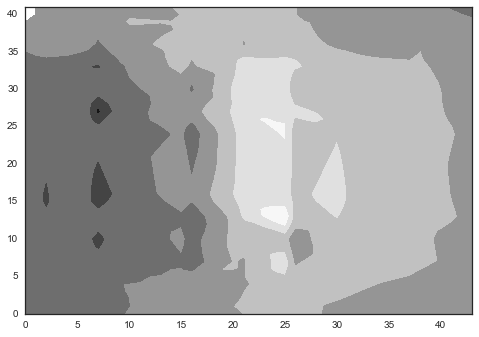

In [57]:
plt.contourf(b_field[1][0][:,:,0])

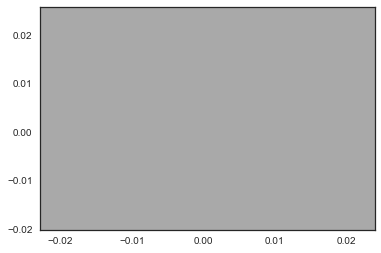

In [365]:
plt.contourf(mesh[0][:,:,0], mesh[1][:,:,0], 
             np.isnan(b_field[1][0][:,:,0]))

In [284]:
mesh[0][:, :, 0]

array([[-0.02395918, -0.02293878, -0.02191837, ...,  0.02195918,
         0.02297959,  0.024     ],
       [-0.02395918, -0.02293878, -0.02191837, ...,  0.02195918,
         0.02297959,  0.024     ],
       [-0.02395918, -0.02293878, -0.02191837, ...,  0.02195918,
         0.02297959,  0.024     ],
       ..., 
       [-0.02395918, -0.02293878, -0.02191837, ...,  0.02195918,
         0.02297959,  0.024     ],
       [-0.02395918, -0.02293878, -0.02191837, ...,  0.02195918,
         0.02297959,  0.024     ],
       [-0.02395918, -0.02293878, -0.02191837, ...,  0.02195918,
         0.02297959,  0.024     ]])

In [285]:
mesh[1][:, :, 0].shape

(46, 48)

In [286]:
b_field[0][0][:, :, 0].shape

(46, 48)

In [287]:
b_field[1][0][:, :, 0].shape

(46, 48)

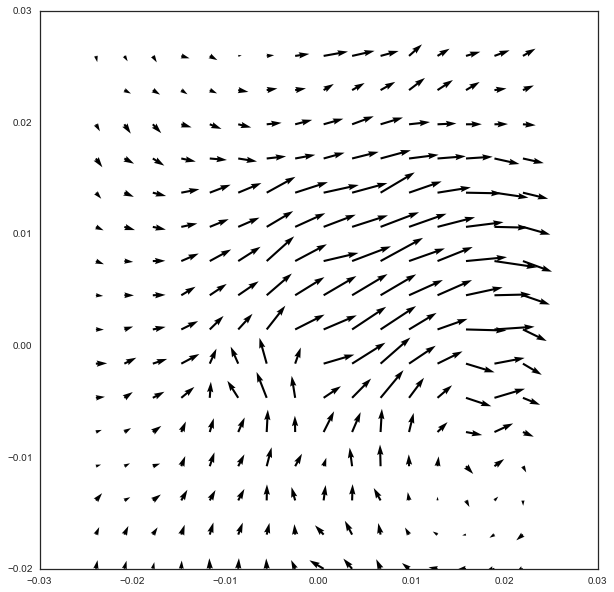

In [288]:
fig = plt.figure(figsize=(10,10))
plt.quiver(mesh[0][:, :, 0][::3, ::3], mesh[1][:, :, 0][::3, ::3], 
           b_field[0][3][:, :, 0][::3, ::3], b_field[1][3][:, :, 0][::3, ::3])

# Make Bx,y plot in 0.249 plane

# Maybe I have to interpolate in x-y planes first and then interpolate between them with regulargrid.

# No that is not necessary. Visit will not read a raveled meshgrid ordered array correctly. The axes need to be swapped.

In [ ]:
date = '2016-07-29'
bx_derivative_meshes = triangulate_derivatives(mesh, bx_triangulation, bx_interpolators, 
                                               increment=0.0000001)
mesh, bx_derivative_meshes = remove_edges(mesh, bx_derivative_meshes)

In [93]:
np.sum(np.isnan(bx_derivative_meshes[19][0][:,:,:]))

0

In [94]:
date = '2016-07-29'
by_derivative_meshes = triangulate_derivatives(mesh, by_triangulation, by_interpolators, 
                                               increment=0.0000001)
mesh, by_derivative_meshes = remove_edges(mesh, by_derivative_meshes)
x, y, z, dby_all_time = prepare_for_rectilinear_grid(mesh, by_derivative_meshes, 
                                                     ['dby_dx', 'dby_dy', 'dby_dz'])
write_derivatives_to_structured_mesh(date, 'dby', mesh, x, y, z, dby_all_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


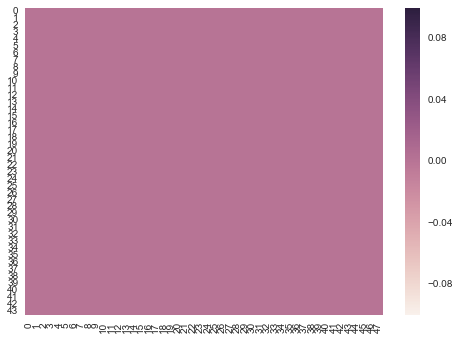

In [96]:
sns.heatmap(np.isnan(by_derivative_meshes[5][2][:,:,0]))
plt.show()

In [98]:
print np.sum(np.isnan(by_derivative_meshes[0][0][:,:,:]))

0


In [99]:
date = '2016-07-29'
bz_derivative_meshes = triangulate_derivatives(mesh, bz_triangulation, bz_interpolators, 
                                               increment=0.0000001)
mesh, bz_derivative_meshes = remove_edges(mesh, bz_derivative_meshes)
x, y, z, dbz_all_time = prepare_for_rectilinear_grid(mesh, bz_derivative_meshes, 
                                                     ['dbz_dx', 'dbz_dy', 'dbz_dz'])
write_derivatives_to_structured_mesh(date, 'dbz', mesh, x, y, z, dbz_all_time)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


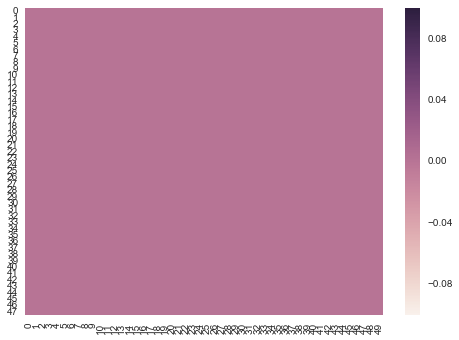

In [69]:
sns.heatmap(np.isnan(bz_derivative_meshes[5][2][:,:,0]))
plt.show()

In [100]:
np.unique(np.where(np.isnan(bz_derivative_meshes[0][1][:,:,:])))

array([], dtype=int64)

In [101]:
print np.sum(np.isnan(bz_derivative_meshes[0][1])[:,:,:])

0


In [143]:
points = np.swapaxes(np.asarray([mesh[0].ravel(), mesh[1].ravel(), mesh[2].ravel()]), 0, 1)

In [144]:
points

array([[-0.02497959, -0.02      ,  0.249     ],
       [-0.02497959, -0.02      ,  0.25000602],
       [-0.02497959, -0.02      ,  0.25101205],
       ..., 
       [ 0.024     ,  0.02595745,  0.41298193],
       [ 0.024     ,  0.02595745,  0.41398795],
       [ 0.024     ,  0.02595745,  0.41499398]])

In [132]:
points

array([[-0.02497959, -0.02      ,  0.249     ],
       [-0.02497959, -0.02      ,  0.25000602],
       [-0.02497959, -0.02      ,  0.25101205],
       ..., 
       [ 0.024     ,  0.02595745,  0.41298193],
       [ 0.024     ,  0.02595745,  0.41398795],
       [ 0.024     ,  0.02595745,  0.41499398]])